# 

---
    Title: filmtheater analysis with python
    Author: Bart Deijkers (bartdeijkers@gmail.com)
    Date: 2022-11-01
---


# STEP 1: Load essentials

In [95]:
import json
import os
import re
import sys
from io import StringIO
import csv

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import PyPDF2
import spacy
import textacy
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFPageInterpreter, PDFResourceManager
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

nltk.download('stopwords')

from nltk.corpus import stopwords
from wordcloud import WordCloud

ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    BASE_DIR = "/content"
    print("You are working on Google Colab.")
    print(f'Files will be downloaded to "{BASE_DIR}".')
else:
    BASE_DIR = ".."
    print("You are working on a local system.")
    print(f'Files will be searched relative to "{BASE_DIR}".')


if spacy.prefer_gpu():
 print("Working on GPU.")
else:
 print("No GPU found, working on CPU.")

stopword_list = stopwords.words('dutch')

# Load dutch tokenizer, tagger, parser and NER
# download and install the model with: 
# $ python -m spacy download nl_core_news_lg
nlp = spacy.load("nl_core_news_lg")

# increase the maximum length of the corpus if available/needed (default is 1M)
# based on step 3 below
nlp.max_length = 2000000

print("done")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


You are working on a local system.
Files will be searched relative to "..".
Working on GPU.
done


# STEP 2: Load dataset

In [96]:
def convert_pdf_to_string(file_path):
	output_string = StringIO()
	with open(file_path, 'rb') as in_file:
		parser = PDFParser(in_file)
		doc = PDFDocument(parser)
		rsrcmgr = PDFResourceManager()
		device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
		interpreter = PDFPageInterpreter(rsrcmgr, device)
		for page in PDFPage.create_pages(doc):
			interpreter.process_page(page)

	return(output_string.getvalue())

                
def convert_title_to_filename(title):
    filename = title.lower()
    filename = filename.replace(' ', '_')
    return filename


def split_to_title_and_pagenum(table_of_contents_entry):
    title_and_pagenum = table_of_contents_entry.strip()
    
    title = None
    pagenum = None
    
    if len(title_and_pagenum) > 0:
        if title_and_pagenum[-1].isdigit():
            i = -2
            while title_and_pagenum[i].isdigit():
                i -= 1

            title = title_and_pagenum[:i].strip()
            pagenum = int(title_and_pagenum[i:].strip())
        
    return title, pagenum



In [97]:
# read all pdf files in folder (change to your own folder if needed)
dataset = "./data/"
pdf_files = [f for f in os.listdir(dataset) if f.endswith(".pdf")]

nouns = []
nouns_filtered_no_stop = []


# loop over all pdf files
for pdf_file in pdf_files:
    text = convert_pdf_to_string(dataset + pdf_file)
  
    # nlp the text
    doc = nlp(text)
    
    # add to noun chunks if noun chunk has 2 or more words
    nouns.extend([t for t in doc if t.pos_ in ['NOUN', 'PROPN']])
    
    # filter out stop words
    nouns_filtered_no_stop.extend([t for t in nouns if t.text.lower() not in stopword_list])

# STEP 3 : Check dataset boundaries (should be under 2000000)

In [98]:
print("Text length:", len(text))

if len(text) > 2000000:
    print("this text is too long for spacy, please split it up in smaller chunks, or increase the maximum length of the corpus")
else:
    print("No boundaries reached, processing text")

print('done')

Text length: 35376
No boundaries reached, processing text
done


# STEP 4: Process text

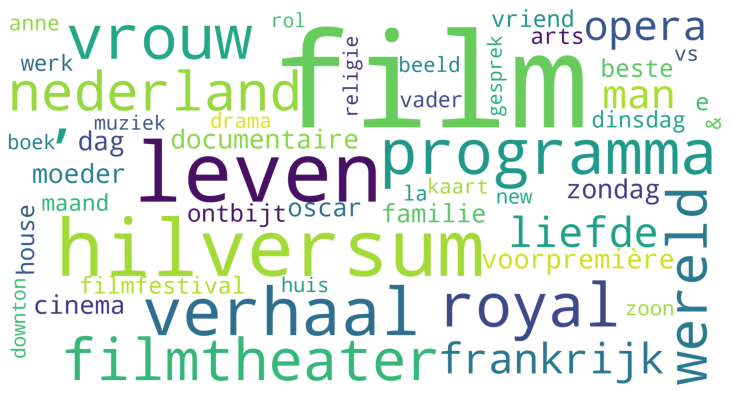

done


In [99]:
# create wordcloud from all noun chunks (top 50)
def get_word_freq(doc):
    word_freq = {}
    for word in doc:
        if word.lemma_.lower() in word_freq.keys():
            word_freq[word.lemma_.lower()] += 1
        else:
            word_freq[word.lemma_.lower()] = 1

    result = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    # return first column of result
    return result

# filter extra filmtheater stop words from nouns_filtered_no_stop
nouns_filtered_no_stop = [t for t in nouns_filtered_no_stop if t.text.lower() not in ['€','ma','di','wo','do','vr','za','zo','tijd','regie','regisseur','min.','uur','jaar','the','januari', 'februari', 'maart', 'april', 'mei', 'juni', 'juli', 'augustus', 'september', 'oktober', 'november', 'december']]


# get top 50 words

wordcloud = WordCloud(width = 1920, height = 1024,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(dict(get_word_freq(nouns_filtered_no_stop)[:50]))
                
# plot the WordCloud image
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()
print('done')

